In [153]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding

import matplotlib.pyplot as plt
%matplotlib inline

In [154]:
tweets = pd.read_csv("tweets.csv")

In [155]:
import emoji
def deEmoji(text):
    return emoji.get_emoji_regexp().sub(r'', text)

In [175]:
# Preprocess
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

def text_preprocess(text):
    text = re.sub(r'#', '', text) #Replace the # symbol with '' in every tweet
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text) #Replace hyperlinks with '' in every tweet
    text = re.sub(r'[^\w\d\s]+', '', text) #Remove all punctuations
    text = deEmoji(text) #Remove emoji
    text = re.sub(r'\n', '', text) #Remove \n
    
    #Remove all stopwords
    stopwords_eng = stopwords.words('english')
    pattern = re.compile(r'\b(' + r'|'.join(stopwords_eng) + r')\b\s*')
    text = pattern.sub('', text)
    
    #Apply stem
    ps = PorterStemmer()
    tk = TweetTokenizer(preserve_case=False, strip_handles = True)
    tweet_tokens = tk.tokenize(text)
    tweet_finish = ''
    for token in tweet_tokens:
        stem = ps.stem(token)
        tweet_finish += (stem + ' ')
    return tweet_finish  

In [157]:
tweets.head()

,Unnamed: 0,status_id,medical_device,text,user_id,created_at,screen_name,source,display_text_width,reply_to_status_id,...,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,query
0,1,1295193004144242690,False,Y’all know and I know I’m never leaving this b...,1255365753517285376,2020-08-17 02:57:30,dtmjasminee,Twitter for iPhone,63,NaN,...,488,2020-04-29 05:18:22,0,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/12553657...,NaN,http://pbs.twimg.com/profile_images/1274031744...,#jnj
1,2,1300190881467846656,False,@SuperKelli24 Such a funny scene! #JnJ,133471182,2020-08-30 21:57:17,Amyreader100,Twitter for iPad,24,1.300187e+18,...,159044,2010-04-15 22:06:08,0,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/13347118...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1213468646...,#jnj
2,3,1299699123428290561,False,"J&amp;JOHNSON, Flag-Formation Confirmed, Conti...",1142737563481980931,2020-08-29 13:23:12,VincePrince244,TradingView,100,NaN,...,38599,2019-06-23 10:14:00,0,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/11427375...,NaN,http://pbs.twimg.com/profile_images/1160910657...,#jnj
3,4,1299558944982134784,False,$JNJ's daily RSI hasn't touched 69 since its F...,1282487181211168769,2020-08-29 04:06:11,options__edge,Twitter Web App,155,NaN,...,247,2020-07-13 01:29:36,0,https://t.co/qlZko56SxU,http://optionsedge.io,NaN,https://pbs.twimg.com/profile_banners/12824871...,NaN,http://pbs.twimg.com/profile_images/1285053865...,#jnj
4,5,1299474674066305024,False,We have an outstanding opportunity to join our...,1705053332,2020-08-28 22:31:20,CaliforniaLopez,LinkedIn,278,NaN,...,1565,2013-08-27 16:12:51,0,https://t.co/ZjjMOq2pu3,http://careers.jnj.com,NaN,NaN,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/4431589516...,#jnj


In [158]:
tweets.describe()

,Unnamed: 0,status_id,user_id,display_text_width,reply_to_status_id,reply_to_user_id,is_quote,is_retweet,favorite_count,retweet_count,...,retweet_description,retweet_verified,protected,followers_count,friends_count,listed_count,statuses_count,favourites_count,verified,account_lang
count,4640.000000,4.640000e+03,4.640000e+03,4640.000000,1.179000e+03,1.302000e+03,4640.000000,4640.0,4640.000000,4640.000000,...,0.0,0.0,4640.0,4.640000e+03,4640.000000,4640.00000,4.640000e+03,4640.000000,4640.000000,0.0
mean,2320.500000,1.346441e+18,3.546603e+17,170.465948,1.331920e+18,2.679447e+17,0.130819,0.0,3.466810,1.073707,...,NaN,NaN,0.0,5.187643e+03,1042.906466,73.00000,3.118775e+04,15615.714224,0.050647,NaN
std,1339.596954,7.304407e+16,5.165250e+17,88.319989,7.314198e+16,4.553111e+17,0.337239,0.0,15.710691,9.411743,...,NaN,NaN,0.0,6.338350e+04,1810.748551,233.52257,1.450083e+05,43138.028185,0.219299,NaN
min,1.000000,1.224230e+18,1.742701e+06,9.000000,1.011252e+18,4.283330e+05,0.000000,0.0,0.000000,0.000000,...,NaN,NaN,0.0,0.000000e+00,0.000000,0.00000,0.000000e+00,0.000000,0.000000,NaN
25%,1160.750000,1.297489e+18,1.735943e+08,89.000000,1.266217e+18,1.388450e+08,0.000000,0.0,0.000000,0.000000,...,NaN,NaN,0.0,1.487500e+02,182.000000,1.00000,9.697500e+02,174.750000,0.000000,NaN
50%,2320.500000,1.331629e+18,1.623827e+09,176.000000,1.325616e+18,1.716283e+09,0.000000,0.0,1.000000,0.000000,...,NaN,NaN,0.0,5.365000e+02,421.500000,8.00000,4.414000e+03,1836.000000,0.000000,NaN
75%,3480.250000,1.408867e+18,8.889435e+17,261.000000,1.395494e+18,7.778192e+17,0.000000,0.0,3.000000,0.000000,...,NaN,NaN,0.0,1.691250e+03,1219.000000,40.00000,1.719800e+04,12079.250000,0.000000,NaN
max,4640.000000,1.491378e+18,1.486798e+18,316.000000,1.491118e+18,1.466252e+18,1.000000,0.0,571.000000,318.000000,...,NaN,NaN,0.0,3.942088e+06,42090.000000,4930.00000,2.359718e+06,630488.000000,1.000000,NaN


In [159]:
temp = tweets.groupby('medical_device').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,medical_device,text
0,False,4157
1,True,483


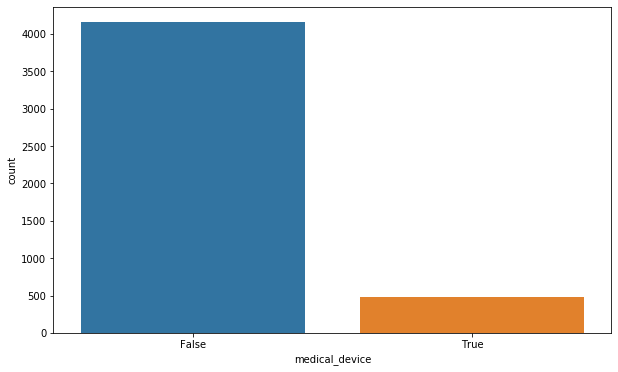

In [160]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.countplot(x='medical_device',data=tweets)
plt.savefig('proportion1.png')

In [161]:
from plotly import graph_objs as go

fig = go.Figure(go.Funnelarea(
    text =temp.medical_device,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of medical_device"}
    ))
fig.write_image("proportion2.png")
fig.show()

In [162]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [163]:
tweets['Num_words'] = tweets['text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text

In [164]:
tweets.head()

,Unnamed: 0,status_id,medical_device,text,user_id,created_at,screen_name,source,display_text_width,reply_to_status_id,...,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,query,Num_words
0,1,1295193004144242690,False,Y’all know and I know I’m never leaving this b...,1255365753517285376,2020-08-17 02:57:30,dtmjasminee,Twitter for iPhone,63,NaN,...,2020-04-29 05:18:22,0,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/12553657...,NaN,http://pbs.twimg.com/profile_images/1274031744...,#jnj,13
1,2,1300190881467846656,False,@SuperKelli24 Such a funny scene! #JnJ,133471182,2020-08-30 21:57:17,Amyreader100,Twitter for iPad,24,1.300187e+18,...,2010-04-15 22:06:08,0,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/13347118...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1213468646...,#jnj,6
2,3,1299699123428290561,False,"J&amp;JOHNSON, Flag-Formation Confirmed, Conti...",1142737563481980931,2020-08-29 13:23:12,VincePrince244,TradingView,100,NaN,...,2019-06-23 10:14:00,0,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/11427375...,NaN,http://pbs.twimg.com/profile_images/1160910657...,#jnj,9
3,4,1299558944982134784,False,$JNJ's daily RSI hasn't touched 69 since its F...,1282487181211168769,2020-08-29 04:06:11,options__edge,Twitter Web App,155,NaN,...,2020-07-13 01:29:36,0,https://t.co/qlZko56SxU,http://optionsedge.io,NaN,https://pbs.twimg.com/profile_banners/12824871...,NaN,http://pbs.twimg.com/profile_images/1285053865...,#jnj,31
4,5,1299474674066305024,False,We have an outstanding opportunity to join our...,1705053332,2020-08-28 22:31:20,CaliforniaLopez,LinkedIn,278,NaN,...,2013-08-27 16:12:51,0,https://t.co/ZjjMOq2pu3,http://careers.jnj.com,NaN,NaN,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/4431589516...,#jnj,34


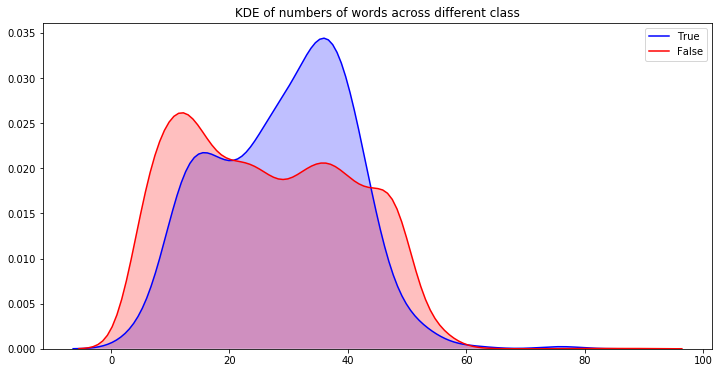

In [165]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(tweets[tweets['medical_device']==True]['Num_words'], shade=True, color="b").set_title('KDE of numbers of words across different class')
p2=sns.kdeplot(tweets[tweets['medical_device']==False]['Num_words'], shade=True, color="r")
plt.legend(labels=['True','False'])
plt.savefig('KDE')
plt.show()

In [166]:
tweets[tweets['medical_device']==True]

,Unnamed: 0,status_id,medical_device,text,user_id,created_at,screen_name,source,display_text_width,reply_to_status_id,...,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,query,Num_words
20,21,1297945036940808192,True,C-SATS started as a research project at the @U...,3166000867,2020-08-24 17:13:06,CSATSinc,Sprout Social,222,NaN,...,2015-04-20 22:09:38,0,http://t.co/nfUfQ0G1dr,http://www.csats.com/,NaN,https://pbs.twimg.com/profile_banners/31660008...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1169368804...,#jnj,29
40,41,1296289194822651905,True,@sambitswaraj needs some clear glasses. Try #j...,701409756,2020-08-20 03:33:22,adzynamic,Twitter for Android,110,NaN,...,2012-07-17 17:08:19,0,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/70140975...,http://abs.twimg.com/images/themes/theme14/bg.gif,http://pbs.twimg.com/profile_images/1258108264...,#jnj,18
45,46,1296160913112932352,True,"ICYMI: @huzefafn, Vice President, #JNJ Digita...",3166000867,2020-08-19 19:03:37,CSATSinc,Twitter Web App,260,NaN,...,2015-04-20 22:09:38,0,http://t.co/nfUfQ0G1dr,http://www.csats.com/,NaN,https://pbs.twimg.com/profile_banners/31660008...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1169368804...,#jnj,27
66,67,1294375742583832583,True,Don’t miss out! Register for our complimentary...,3166000867,2020-08-14 20:50:00,CSATSinc,Twitter for iPhone,273,NaN,...,2015-04-20 22:09:38,0,http://t.co/nfUfQ0G1dr,http://www.csats.com/,NaN,https://pbs.twimg.com/profile_banners/31660008...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1169368804...,#jnj,33
69,70,1293925500528791553,True,Biosense Webster receives CE mark approval for...,473416032,2020-08-13 15:00:53,kelly_rkelly,Twitter Web App,115,NaN,...,2012-01-24 23:28:32,0,NaN,NaN,NaN,NaN,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9224008823...,#jnj,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4630,4631,1488183234085203980,True,#MedEdWest surgical trainees and medical stude...,730410919,2022-01-31 16:11:46,McgeeSinead,Twitter for iPad,207,NaN,...,2012-08-01 10:15:09,0,NaN,NaN,NaN,NaN,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1321614783...,"""ETHICON""",24
4631,4632,1488167498902130689,True,TOMORROW | Hear about managing LINX patients f...,991959173847048192,2022-01-31 15:09:15,EndoscopyNow,Twitter Web App,265,NaN,...,2018-05-03 08:34:31,0,https://t.co/66uXRIN2qh,http://www.endoscopynow.com,NaN,https://pbs.twimg.com/profile_banners/99195917...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9961238233...,"""ETHICON""",31
4632,4633,1488124893581430785,True,@Weebrian @WesternHSCTrust Morning session in ...,812916565,2022-01-31 12:19:57,boyce_kathryn,Twitter for iPhone,85,1.487130e+18,...,2012-09-09 11:12:51,0,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/81291656...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1453442395...,"""ETHICON""",16
4634,4635,1491117699447275521,True,Biosense Webster is part of the Johnson&amp;Jo...,1363691492099977217,2022-02-08 18:32:17,med_tec2,Twitter for iPhone,280,1.491118e+18,...,2021-02-22 03:26:17,0,https://t.co/r4h4F0pH8l,http://tec2med.pt/,NaN,https://pbs.twimg.com/profile_banners/13636914...,NaN,http://pbs.twimg.com/profile_images/1363691861...,"""BIOSENSE WEBSTER""",39


In [167]:
k = tweets[tweets['Num_words']<=5]

In [168]:
k[k['medical_device']==True]

,Unnamed: 0,status_id,medical_device,text,user_id,created_at,screen_name,source,display_text_width,reply_to_status_id,...,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,query,Num_words
2671,2672,1343768575241293824,True,@Ethicon What is surgical smoke?,1055579178,2020-12-29 03:59:29,Strong4895,Twitter for iPad,23,1.336038e+18,...,2013-01-02 17:02:14,0,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/10555791...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1152961585...,ethicon,5
2802,2803,1355833901172846595,True,Hermonic Ethicon Whatsapp +923157651238 https:...,1129470938402238466,2021-01-31 11:02:46,ajwa_surgical,Twitter for Android,39,NaN,...,2019-05-17 19:37:11,0,https://t.co/wCRwXkk4jn,http://www.ajwasurgical.com,NaN,https://pbs.twimg.com/profile_banners/11294709...,NaN,http://pbs.twimg.com/profile_images/1129471138...,ethicon,5
4099,4100,1490611222105915392,True,Gastrointestinal Devices Market\nhttps://t.co/...,1483679086660964358,2022-02-07 08:59:44,sai_konapure,Twitter Web App,55,NaN,...,2022-01-19 05:54:26,0,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/1483679221...,"""ETHICON""",4
4100,4101,1488502525384749057,True,Tumor Ablation Devices Market\nhttps://t.co/bp...,1483679086660964358,2022-02-01 13:20:31,sai_konapure,Twitter Web App,53,NaN,...,2022-01-19 05:54:26,0,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/1483679221...,"""ETHICON""",5
4635,4636,1490948786650157059,True,Cardiac Mapping Market\nhttps://t.co/oBNqvTHD3W,1483738702417625092,2022-02-08 07:21:05,Samuela69713106,Twitter Web App,46,NaN,...,2022-01-19 09:51:02,0,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/1483738764...,"""BIOSENSE WEBSTER""",4


In [169]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    #text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [170]:
tweets['text2'] = tweets['text'].apply(lambda x:text_preprocess(x))
tweets['text3'] = tweets['text'].apply(lambda x:clean_text(x))

In [171]:
tweets.head()

,Unnamed: 0,status_id,medical_device,text,user_id,created_at,screen_name,source,display_text_width,reply_to_status_id,...,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,query,Num_words,text2,text3
0,1,1295193004144242690,False,Y’all know and I know I’m never leaving this b...,1255365753517285376,2020-08-17 02:57:30,dtmjasminee,Twitter for iPhone,63,NaN,...,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/12553657...,NaN,http://pbs.twimg.com/profile_images/1274031744...,#jnj,13,yall know i know im never leav boy alon jnj,y’all know and i know i’m never leaving this b...
1,2,1300190881467846656,False,@SuperKelli24 Such a funny scene! #JnJ,133471182,2020-08-30 21:57:17,Amyreader100,Twitter for iPad,24,1.300187e+18,...,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/13347118...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1213468646...,#jnj,6,superkelli 24 such funni scene jnj,@ such a funny scene! #jnj
2,3,1299699123428290561,False,"J&amp;JOHNSON, Flag-Formation Confirmed, Conti...",1142737563481980931,2020-08-29 13:23:12,VincePrince244,TradingView,100,NaN,...,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/11427375...,NaN,http://pbs.twimg.com/profile_images/1160910657...,#jnj,9,jampjohnson flagform confirm continu possibl j...,"j&amp;johnson, flag-formation confirmed, conti..."
3,4,1299558944982134784,False,$JNJ's daily RSI hasn't touched 69 since its F...,1282487181211168769,2020-08-29 04:06:11,options__edge,Twitter Web App,155,NaN,...,https://t.co/qlZko56SxU,http://optionsedge.io,NaN,https://pbs.twimg.com/profile_banners/12824871...,NaN,http://pbs.twimg.com/profile_images/1285053865...,#jnj,31,jnj daili rsi hasnt touch 69 sinc februari 202...,$jnj's daily rsi hasn't touched since its feb...
4,5,1299474674066305024,False,We have an outstanding opportunity to join our...,1705053332,2020-08-28 22:31:20,CaliforniaLopez,LinkedIn,278,NaN,...,https://t.co/ZjjMOq2pu3,http://careers.jnj.com,NaN,NaN,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/4431589516...,#jnj,34,we outstand opportun join non clinic safeti te...,we have an outstanding opportunity to join our...


In [177]:
from collections import Counter
tweets['temp_list'] = tweets['text2'].apply(lambda x:str(x).split())
top = Counter([item for sublist in tweets['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,jnj,3728
1,i,842
2,amp,785
3,johnson,608
4,ethicon,564
5,the,340
6,bwi,269
7,sol,254
8,pfe,242
9,love,240


In [178]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
tweets['temp_list3'] = tweets['temp_list'].apply(lambda x:remove_stopword(x))

In [179]:
tweets

,Unnamed: 0,status_id,medical_device,text,user_id,created_at,screen_name,source,display_text_width,reply_to_status_id,...,account_lang,profile_banner_url,profile_background_url,profile_image_url,query,Num_words,text2,text3,temp_list,temp_list3
0,1,1295193004144242690,False,Y’all know and I know I’m never leaving this b...,1255365753517285376,2020-08-17 02:57:30,dtmjasminee,Twitter for iPhone,63,NaN,...,NaN,https://pbs.twimg.com/profile_banners/12553657...,NaN,http://pbs.twimg.com/profile_images/1274031744...,#jnj,13,yall know i know im never leav boy alon jnj,y’all know and i know i’m never leaving this b...,"[yall, know, i, know, im, never, leav, boy, al...","[yall, know, know, im, never, leav, boy, alon,..."
1,2,1300190881467846656,False,@SuperKelli24 Such a funny scene! #JnJ,133471182,2020-08-30 21:57:17,Amyreader100,Twitter for iPad,24,1.300187e+18,...,NaN,https://pbs.twimg.com/profile_banners/13347118...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1213468646...,#jnj,6,superkelli 24 such funni scene jnj,@ such a funny scene! #jnj,"[superkelli, 24, such, funni, scene, jnj]","[superkelli, 24, funni, scene, jnj]"
2,3,1299699123428290561,False,"J&amp;JOHNSON, Flag-Formation Confirmed, Conti...",1142737563481980931,2020-08-29 13:23:12,VincePrince244,TradingView,100,NaN,...,NaN,https://pbs.twimg.com/profile_banners/11427375...,NaN,http://pbs.twimg.com/profile_images/1160910657...,#jnj,9,jampjohnson flagform confirm continu possibl j...,"j&amp;johnson, flag-formation confirmed, conti...","[jampjohnson, flagform, confirm, continu, poss...","[jampjohnson, flagform, confirm, continu, poss..."
3,4,1299558944982134784,False,$JNJ's daily RSI hasn't touched 69 since its F...,1282487181211168769,2020-08-29 04:06:11,options__edge,Twitter Web App,155,NaN,...,NaN,https://pbs.twimg.com/profile_banners/12824871...,NaN,http://pbs.twimg.com/profile_images/1285053865...,#jnj,31,jnj daili rsi hasnt touch 69 sinc februari 202...,$jnj's daily rsi hasn't touched since its feb...,"[jnj, daili, rsi, hasnt, touch, 69, sinc, febr...","[jnj, daili, rsi, hasnt, touch, 69, sinc, febr..."
4,5,1299474674066305024,False,We have an outstanding opportunity to join our...,1705053332,2020-08-28 22:31:20,CaliforniaLopez,LinkedIn,278,NaN,...,NaN,NaN,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/4431589516...,#jnj,34,we outstand opportun join non clinic safeti te...,we have an outstanding opportunity to join our...,"[we, outstand, opportun, join, non, clinic, sa...","[outstand, opportun, join, non, clinic, safeti..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4635,4636,1490948786650157059,True,Cardiac Mapping Market\nhttps://t.co/oBNqvTHD3W,1483738702417625092,2022-02-08 07:21:05,Samuela69713106,Twitter Web App,46,NaN,...,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/1483738764...,"""BIOSENSE WEBSTER""",4,cardiac map market,cardiac mapping market,"[cardiac, map, market]","[cardiac, map, market]"
4636,4637,1491170087298076674,False,@ForegutSociety @JNJInstitute @Ethicon @Proxim...,1053822633618243584,2022-02-08 22:00:28,ForegutSociety,Hootsuite Inc.,97,NaN,...,NaN,https://pbs.twimg.com/profile_banners/10538226...,NaN,http://pbs.twimg.com/profile_images/1053826896...,"""ETHICON""",11,foregutsocieti jnjinstitut ethicon proximiear ...,@foregutsociety @jnjinstitute @ethicon @proxim...,"[foregutsocieti, jnjinstitut, ethicon, proximi...","[foregutsocieti, jnjinstitut, ethicon, proximi..."
4637,4638,1491351776620343297,False,Get ready to watch at 8.00pm (Beijing Time) Th...,1217652692,2022-02-09 10:02:26,AISChannel,Twitter Web App,277,NaN,...,NaN,https://pbs.twimg.com/profile_banners/12176526...,http://abs.twimg.com/images/themes/theme14/bg.gif,http://pbs.twimg.com/profile_images/1491317830...,"""ETHICON""",33,get readi watch 800pm beij time the chines per...,get ready to watch at . (beijing time) the chi...,"[get, readi, watch, 800pm, beij, time, t

In [194]:
top = Counter([item for sublist in tweets['temp_list3'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[0:,:]
temp1 = temp.iloc[0:10,:]
temp.columns = ['Common_words','count']
temp1.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
0,jnj,3728
1,amp,785
2,johnson,608
3,ethicon,564
4,bwi,269
5,sol,254
6,pfe,242
7,love,240
8,health,239
9,peopl,239


In [182]:
if 'i' in  stopwords.words('english'):
    print(1)

1


In [195]:
import plotly.express as px
import plotly.figure_factory as ff
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

In [199]:
fig = px.bar(temp1, x="count", y="Common_words", orientation='h', 
             width=500, height=400,color='Common_words')
fig.show()

In [200]:
right_class = tweets[tweets['medical_device']==True]
wrong_class = tweets[tweets['medical_device']==False]

In [201]:
top = Counter([item for sublist in right_class['temp_list3'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,ethicon,264
1,jnj,180
2,amp,151
3,johnson,130
4,mesh,130
5,devic,64
6,medic,50
7,surgic,49
8,market,48
9,use,47


In [206]:
fig = px.bar(temp_positive, x="count", y="Common_words", title= ' common words in tweets about medical device',orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [203]:
top = Counter([item for sublist in wrong_class['temp_list3'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,amp,634
2,johnson,478
3,ethicon,300
4,bwi,269
5,sol,254
6,pfe,242
7,peopl,237
8,love,232
9,uon,231
10,nftart,226


In [209]:
fig = px.bar(temp_negative, x="count", y="Common_words",  title= ' common words in tweets not about medical device',orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [204]:
tweets['temp_list1'] = tweets['text2'].apply(lambda x:str(x).split()) #List of words in every row for text text_preprocess
tweets['temp_list1'] = tweets['temp_list1'].apply(lambda x:remove_stopword(x)) #Removing Stopwords

In [210]:
raw_text = [word for word_list in tweets['temp_list3'] for word in word_list]

In [211]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in tweets[tweets.medical_device != sentiment]['temp_list1']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in tweets[tweets.medical_device == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

In [212]:
Unique_Positive= words_unique(True, 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


,words,count
0,mesh,130
1,stapler,15
2,echelon,13
3,sf,12
4,transvagin,11
5,thermocool,11
6,smarttouch,11
7,vagin,10
8,hip,8
9,bard,8


In [213]:
fig = px.treemap(Unique_Positive, path=['words'], values='count',title='Tree Of Unique Words About Medical Device')
fig.show()

In [214]:
Unique_Negative= words_unique(False, 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


,words,count
0,bwi,269
1,sol,254
2,pfe,242
3,uon,231
4,nftart,226
5,jack,211
6,nkla,147
7,mo,140
8,coin,139
9,24,136


In [217]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(12,10), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()
    plt.savefig('test')

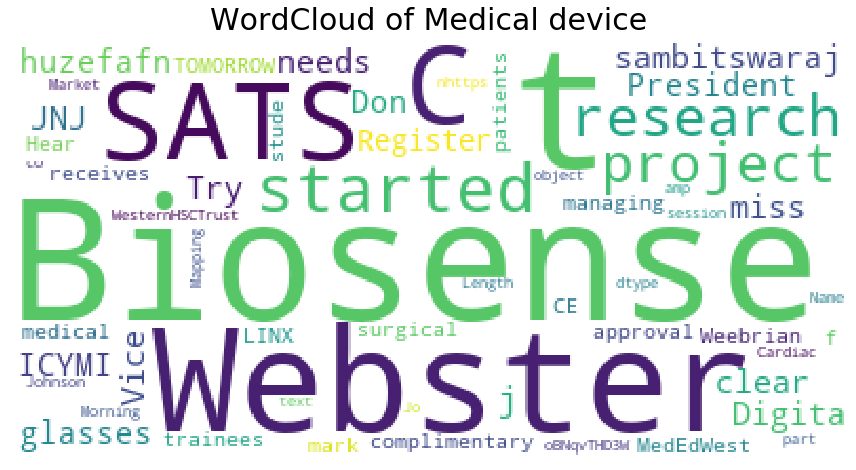

In [218]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#pos_mask = np.array(Image.open('twitter_mask.png'))
plot_wordcloud(right_class.text,color='white',max_font_size=80,title_size=30,title="WordCloud of Medical device")

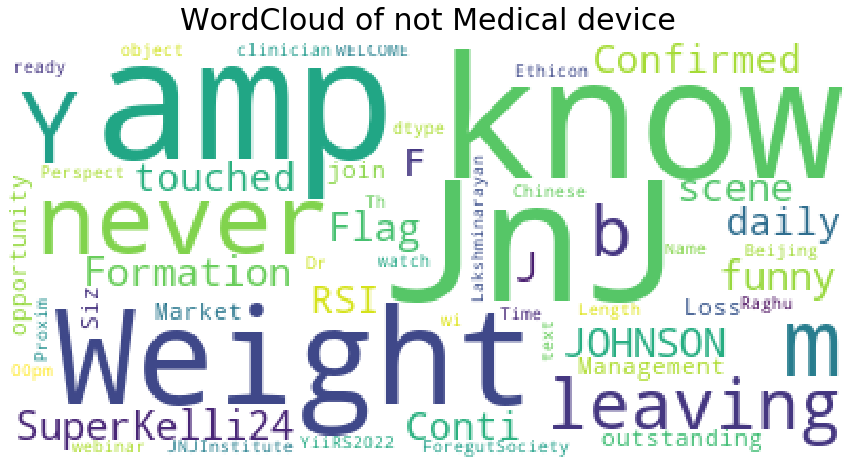

In [66]:
plot_wordcloud(wrong_class.text,color='white',max_font_size=80,title_size=30,title="WordCloud of not Medical device")

model

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tweets["text"], tweets["medical_device"],
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    stratify=tweets["medical_device"],
                                                    random_state=42)

In [74]:
df_train, df_test = train_test_split(tweets[['text','medical_device']], test_size=0.2)

In [75]:
df_train

,text,medical_device
4057,@JNJNews Enjoying D. Leanne Williams presentat...,False
2433,"Beyond impacting patient lives, what I love ab...",False
3403,STATEMENT from #JnJ on doses that the FDA does...,False
1452,@realDonaldTrump @FDA 2014 - ETHICON\nProduct ...,True
1685,#BWI Marshall welcomes Minute Suites https://t...,False
...,...,...
1037,@RTandLikeSoaps #Ericole (Nicole &amp; Eric)\n...,False
659,@DarthSSnape 😂🤣 GOSH! I just laughed at this! ...,False
919,"@JNJGlobalHealth Hi, I wanna know is this a Am...",False
1905,#tbt...Our Medical/Food Outreach to Obere Comm...,False


In [98]:
def save_model(output_dir, nlp, new_model_name):
    ''' This Function Saves model to 
    given output directory'''
    
    output_dir = f'../working/{output_dir}'
    if output_dir is not None:        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        nlp.meta["name"] = new_model_name
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

In [99]:
from spacy.training.example import Example
def train(train_data, output_dir, n_iter=20, model=None):
    """Load the model, set up the pipeline and train the entity recognizer."""
    ""
    if model is not None:
        nlp = spacy.load(output_dir)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        #ner = nlp.create_pipe("ner")
        nlp.add_pipe('ner', last=True)
        ner = nlp.get_pipe("ner")
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")
    
    # add labels
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        # sizes = compounding(1.0, 4.0, 1.001)
        # batch up the examples using spaCy's minibatch
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()


        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data)
            batches = minibatch(train_data, size=compounding(4.0, 500.0, 1.001))    
            losses = {}
            for batch in batches:
#                 texts, annotations = zip(*batch)
                for text, annotations in batch:
                    doc = nlp.make_doc(text)
                    example = Example.from_dict(doc, annotations)
#                 nlp.update(texts,  # batch of texts
#                             annotations,  # batch of annotations
#                             drop=0.5,   # dropout - make it harder to memorise data
#                             losses=losses, 
#                             )
                    nlp.update([example], losses=losses, drop=0.3)
            print("Losses", losses)
    save_model(output_dir, nlp, 'st_ner')

In [100]:
def get_model_out_path(sentiment):
    '''
    Returns Model output path
    '''
    model_out_path = None
    if sentiment == True:
        model_out_path = 'models/model_pos'
    elif sentiment == False:
        model_out_path = 'models/model_neg'
    return model_out_path

In [101]:
def get_training_data(sentiment):
    '''
    Returns Trainong data in the format needed to train spacy NER
    '''
    train_data = []
    for index, row in df_train.iterrows():
        if row.medical_device == sentiment:
            selected_text = row.text
            text = row.text
            start = text.find(text)
            end = start + len(text)
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return train_data

In [102]:
from tqdm import tqdm
from spacy.util import compounding
from spacy.util import minibatch
import random
import os
sentiment = True

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)
# For DEmo Purposes I have taken 3 iterations you can train the model as you want
train(train_data, model_path, n_iter=3, model=None)

  0%|          | 0/3 [00:00<?, ?it/s]

Created blank 'en' model


 33%|███▎      | 1/3 [00:09<00:19,  9.87s/it]

Losses {'ner': 1308.013655244646}


 67%|██████▋   | 2/3 [00:20<00:10, 10.02s/it]

Losses {'ner': 18.528721574487257}


100%|██████████| 3/3 [00:30<00:00, 10.27s/it]

Losses {'ner': 1.8744831837035567}
Saved model to ../working/models/model_pos


In [103]:
sentiment = False

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=3, model=None)

  0%|          | 0/3 [00:00<?, ?it/s]

Created blank 'en' model


 33%|███▎      | 1/3 [01:29<02:58, 89.13s/it]

Losses {'ner': 1057.1190324454933}


 67%|██████▋   | 2/3 [04:07<01:50, 110.04s/it]

Losses {'ner': 19.01705900902718}


100%|██████████| 3/3 [06:44<00:00, 134.74s/it]

Losses {'ner': 9.92753811164133}
Saved model to ../working/models/model_neg


predicting with the trained model

In [104]:
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

In [110]:
selected_texts = []
MODELS_BASE_PATH = '../working/models/'

if MODELS_BASE_PATH is not None:
    print("Loading Models  from ", MODELS_BASE_PATH)
    model_pos = spacy.load(MODELS_BASE_PATH + 'model_pos')
    model_neg = spacy.load(MODELS_BASE_PATH + 'model_neg')
        
    for index, row in df_test.iterrows():
        text = row.text
        output_str = ""
        if row.medical_device == 'neutral' or len(text.split()) <= 2:
            selected_texts.append(text)
        elif row.medical_device == True:
            selected_texts.append(predict_entities(text, model_pos))
        else:
            selected_texts.append(predict_entities(text, model_neg))
        
df_test['selected_text'] = selected_texts

Loading Models  from  ../working/models/
